# Face Generation

### Get the Data
The two datasets in this project:
- MNIST
- CelebA

In [2]:
data_dir = './data'

import check_data

check_data.download_extract('mnist', data_dir)
check_data.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:19<00:00, 3.13KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

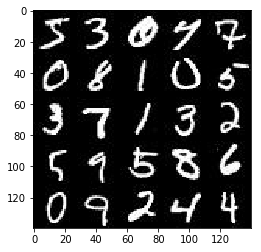

In [3]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = check_data.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(check_data.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

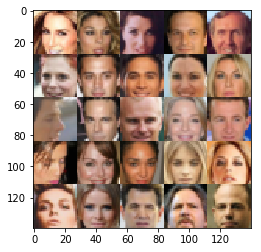

In [4]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/anaconda/envs/dlnd/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input

In [1]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None,image_width, image_height, image_channels],
                                name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate

### Discriminator

In [2]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits

### Generator

In [3]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not(is_train)):
        x1 = tf.layers.dense(z, 7*7*112)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
       
        out = tf.tanh(logits)
    return out

### Loss

In [4]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

### Optimization

In [5]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Neural Network Training
### Show Output

In [6]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train

In [7]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # Normalize input to be between -1 and 1 to match generator's images
                batch_images = batch_images*2
                
                # Get input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST

Epoch 1/2... Discriminator Loss: 2.0344... Generator Loss: 0.2063
Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.4869
Epoch 1/2... Discriminator Loss: 0.3317... Generator Loss: 1.7260
Epoch 1/2... Discriminator Loss: 0.1321... Generator Loss: 2.6029
Epoch 1/2... Discriminator Loss: 0.0544... Generator Loss: 3.3541
Epoch 1/2... Discriminator Loss: 0.0349... Generator Loss: 3.8647
Epoch 1/2... Discriminator Loss: 0.0192... Generator Loss: 4.2978
Epoch 1/2... Discriminator Loss: 0.0182... Generator Loss: 4.3226
Epoch 1/2... Discriminator Loss: 0.0107... Generator Loss: 4.7790


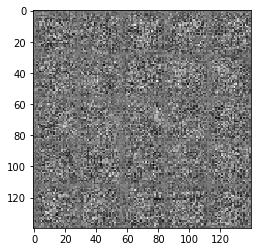

Epoch 1/2... Discriminator Loss: 0.0112... Generator Loss: 4.7389
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 4.7048
Epoch 1/2... Discriminator Loss: 0.0107... Generator Loss: 4.8223
Epoch 1/2... Discriminator Loss: 0.0113... Generator Loss: 4.7809
Epoch 1/2... Discriminator Loss: 0.0096... Generator Loss: 4.9812
Epoch 1/2... Discriminator Loss: 0.0082... Generator Loss: 5.1406
Epoch 1/2... Discriminator Loss: 0.0116... Generator Loss: 4.7344
Epoch 1/2... Discriminator Loss: 0.0084... Generator Loss: 5.1191
Epoch 1/2... Discriminator Loss: 0.0131... Generator Loss: 4.5824
Epoch 1/2... Discriminator Loss: 0.0490... Generator Loss: 3.1977


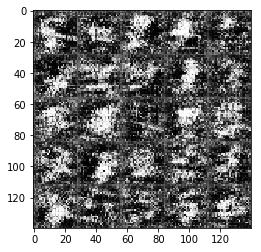

Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 1.4606
Epoch 1/2... Discriminator Loss: 2.2974... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 0.7047... Generator Loss: 1.1807
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 2.0328
Epoch 1/2... Discriminator Loss: 0.2859... Generator Loss: 1.8926
Epoch 1/2... Discriminator Loss: 3.9345... Generator Loss: 9.2563
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.3203
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 3.1194... Generator Loss: 0.1045


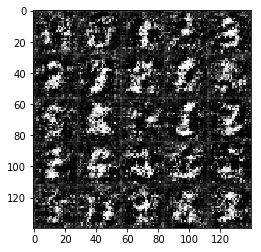

Epoch 1/2... Discriminator Loss: 1.7833... Generator Loss: 0.3334
Epoch 1/2... Discriminator Loss: 2.6328... Generator Loss: 0.0931
Epoch 1/2... Discriminator Loss: 2.9403... Generator Loss: 0.0847
Epoch 1/2... Discriminator Loss: 1.8115... Generator Loss: 0.2384
Epoch 1/2... Discriminator Loss: 2.0556... Generator Loss: 0.1569
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.3135
Epoch 1/2... Discriminator Loss: 2.1668... Generator Loss: 0.1774
Epoch 1/2... Discriminator Loss: 1.8038... Generator Loss: 0.2340
Epoch 1/2... Discriminator Loss: 1.8400... Generator Loss: 0.2186
Epoch 1/2... Discriminator Loss: 1.7192... Generator Loss: 0.2714


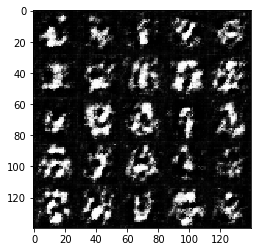

Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 1.3931
Epoch 1/2... Discriminator Loss: 1.7996... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 2.3343... Generator Loss: 0.1433
Epoch 1/2... Discriminator Loss: 2.0679... Generator Loss: 0.1707
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.4002
Epoch 1/2... Discriminator Loss: 1.7937... Generator Loss: 0.2393
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 0.3201
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.3287


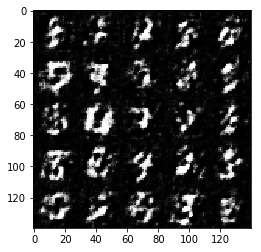

Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.3367
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.3704
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.5373
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 0.6355


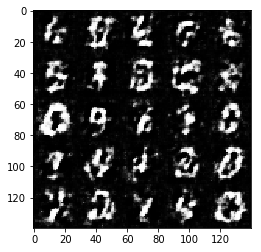

Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.3361
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.4832
Epoch 1/2... Discriminator Loss: 1.6427... Generator Loss: 0.2879
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.3477
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.6508... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.7327


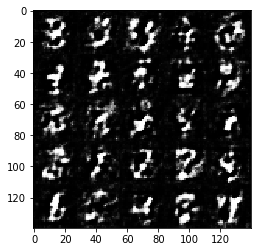

Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 1.5342... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 1.1812
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 0.3746


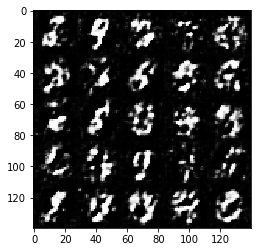

Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 0.3197
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.6921... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.6891... Generator Loss: 0.2850
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.9756


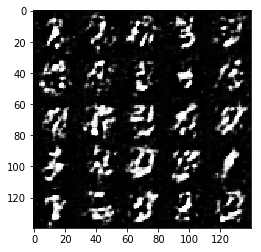

Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.4818
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.2667
Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.4735


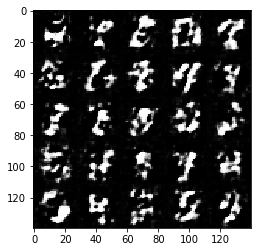

Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.4547
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.0761
Epoch 1/2... Discriminator Loss: 1.6930... Generator Loss: 0.2921


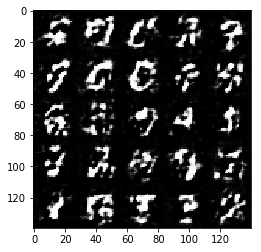

Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.4893
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.7629... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.4310
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 1.0129


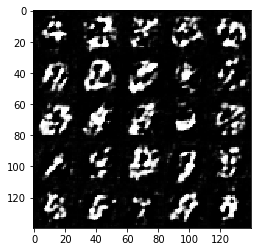

Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.4243
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.5529
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.6402


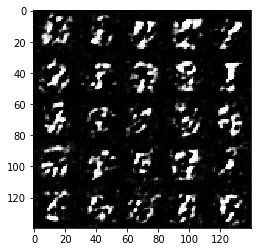

Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.3225
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.5007
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.4052


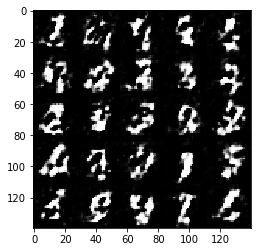

Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.4984
Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.6719


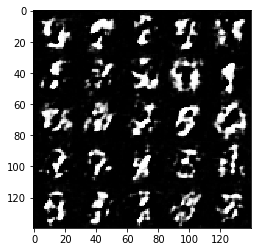

Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 0.4723
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 1.0173
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.4887
Epoch 1/2... Discriminator Loss: 1.5606... Generator Loss: 0.4080
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.4948


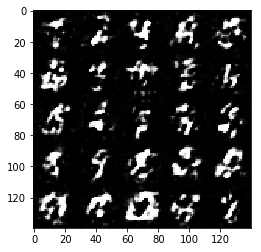

Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.5216
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 1.0171
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.7634


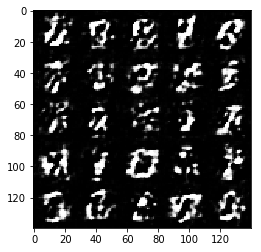

Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.7799... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 0.4521


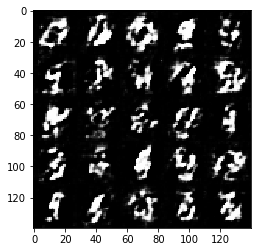

Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.5282... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.5058
Epoch 1/2... Discriminator Loss: 1.5794... Generator Loss: 0.3332
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.5650
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.4282... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.9655


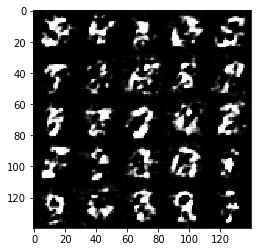

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.8256
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.7572


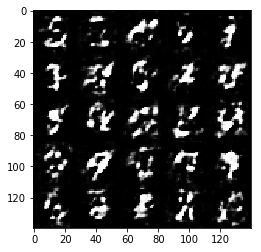

Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 1.1587
Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 1.5690... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.5545... Generator Loss: 0.9050


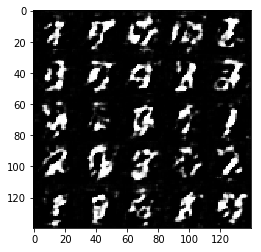

Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.9310
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7204
Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.5828
Epoch 2/2... Discriminator Loss: 1.4720... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.4933... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.6726


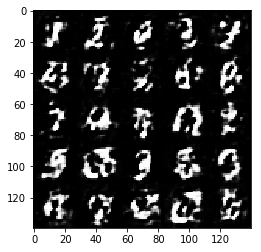

Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.5658... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.4900
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.4378
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.5198


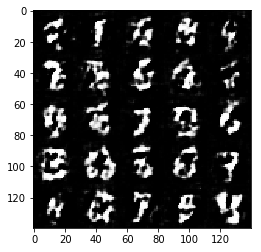

Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 1.5715... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 1.4785... Generator Loss: 0.4251
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.5631
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.9638
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.4596


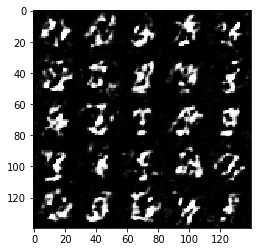

Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.5444... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.4500
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.4159
Epoch 2/2... Discriminator Loss: 1.4645... Generator Loss: 0.5021


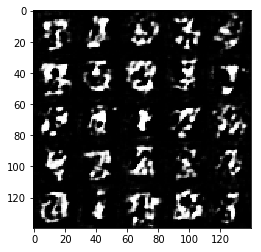

Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.5241
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.5633
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.4444
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.5847
Epoch 2/2... Discriminator Loss: 1.5349... Generator Loss: 0.3423
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.5045... Generator Loss: 1.0186


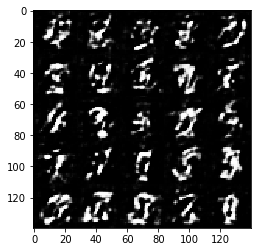

Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.5028
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.5340
Epoch 2/2... Discriminator Loss: 1.5251... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.8538


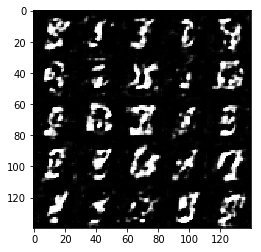

Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.5713... Generator Loss: 0.3489
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.6606
Epoch 2/2... Discriminator Loss: 1.6636... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.5317


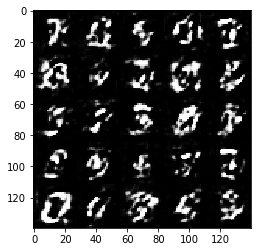

Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.5512
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.7134


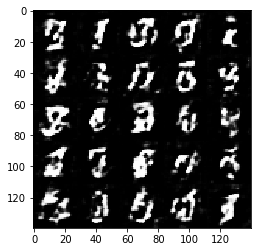

Epoch 2/2... Discriminator Loss: 1.4180... Generator Loss: 0.4774
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.4082
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 1.4964... Generator Loss: 0.4987
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.6357... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 1.5281... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.7781


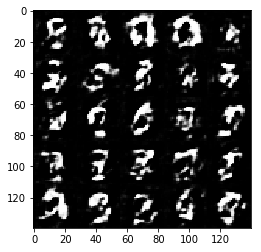

Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.5998
Epoch 2/2... Discriminator Loss: 1.4931... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.4174
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.3903
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6107


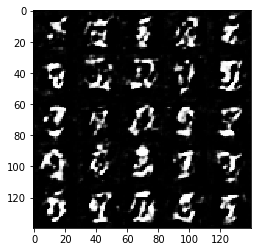

Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.5545
Epoch 2/2... Discriminator Loss: 1.4272... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.5540... Generator Loss: 0.4379
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.5039
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 1.5360... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.9227


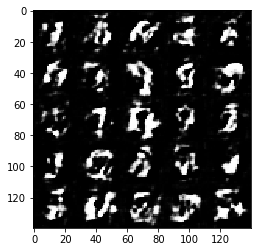

Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.8506
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.4065... Generator Loss: 0.7222
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.5928


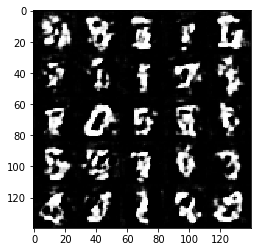

Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.7712
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.9471
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 0.8165


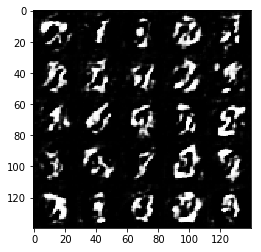

Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.4373... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.4703... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.8977
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.5784... Generator Loss: 0.9521


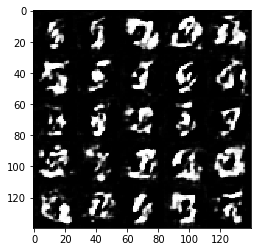

Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 1.6727... Generator Loss: 0.3510
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.7289... Generator Loss: 0.3552


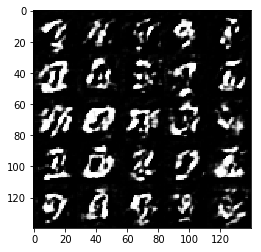

Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.4965
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.5552
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.4808
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.7900
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.5254


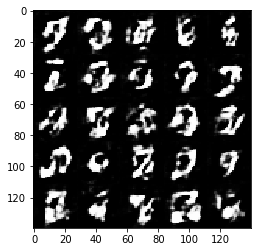

Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.5258
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.5770


In [45]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.3151
Epoch 1/1... Discriminator Loss: 1.6618... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 2.4287
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 2.8641
Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 3.2148
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 3.8490


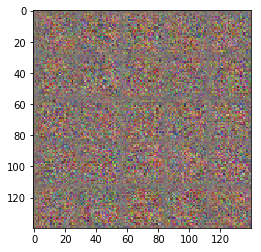

Epoch 1/1... Discriminator Loss: 0.0557... Generator Loss: 3.7256
Epoch 1/1... Discriminator Loss: 0.0225... Generator Loss: 4.5862
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 3.9208
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 4.2520
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 3.7056
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 3.2116
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 2.4006
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.4278
Epoch 1/1... Discriminator Loss: 3.9998... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 2.0345


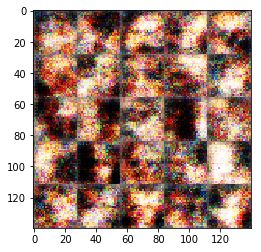

Epoch 1/1... Discriminator Loss: 0.2820... Generator Loss: 2.5950
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 1.7781
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 2.3732
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 0.2731... Generator Loss: 1.9263
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 1.8257
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 1.5677
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 2.1906
Epoch 1/1... Discriminator Loss: 0.3079... Generator Loss: 2.1989


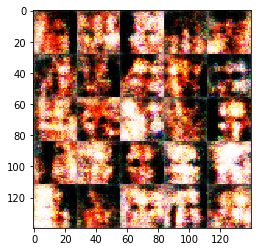

Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 2.6448
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 2.6749
Epoch 1/1... Discriminator Loss: 1.8196... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 2.2944
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 2.5157
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 2.1980
Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 3.0158
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 2.0238


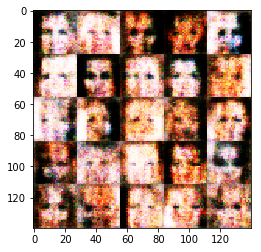

Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 5.4365
Epoch 1/1... Discriminator Loss: 0.2725... Generator Loss: 1.8585
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 5.7736
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 2.0345
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 0.2785... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 2.5618... Generator Loss: 5.5069
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 2.3421


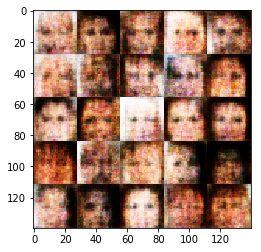

Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 1.7230... Generator Loss: 0.2339
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.6974


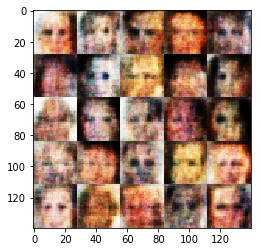

Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.6549
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 0.2267... Generator Loss: 5.3661
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 3.3387
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 2.7213
Epoch 1/1... Discriminator Loss: 0.2608... Generator Loss: 4.0035
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.1553


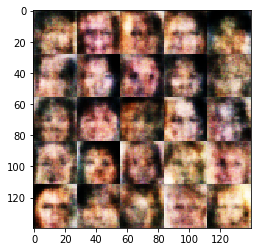

Epoch 1/1... Discriminator Loss: 2.4914... Generator Loss: 0.1075
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.6414
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 2.1610... Generator Loss: 0.1413
Epoch 1/1... Discriminator Loss: 1.8834... Generator Loss: 2.2835
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 3.7706
Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 2.2465
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.9913


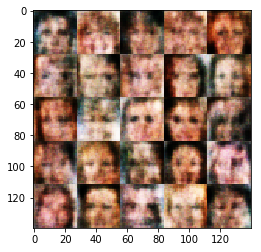

Epoch 1/1... Discriminator Loss: 2.7772... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 2.5532
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 0.0842... Generator Loss: 3.3287
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 4.6662
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 4.7154
Epoch 1/1... Discriminator Loss: 2.2010... Generator Loss: 0.1458


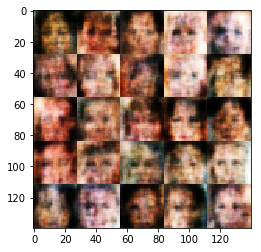

Epoch 1/1... Discriminator Loss: 2.3079... Generator Loss: 0.1509
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.7250
Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 0.2793... Generator Loss: 2.0261
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.0738
Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 4.7398


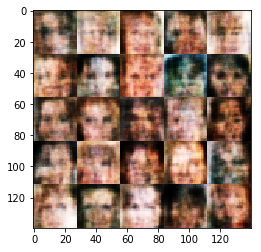

Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 3.2617
Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 4.4550
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 1.7716
Epoch 1/1... Discriminator Loss: 0.1634... Generator Loss: 2.4307
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 4.9292
Epoch 1/1... Discriminator Loss: 0.1002... Generator Loss: 6.8378
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 5.6957
Epoch 1/1... Discriminator Loss: 2.6912... Generator Loss: 0.1056


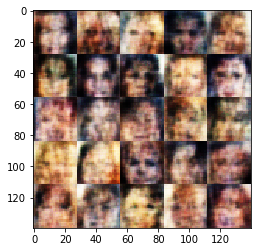

Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.8991... Generator Loss: 0.2353
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 2.3374
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.5351


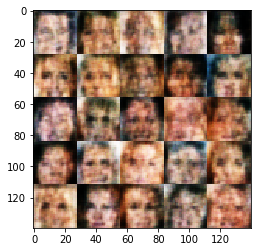

Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 1.9768... Generator Loss: 0.1746
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.8421
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 1.4568


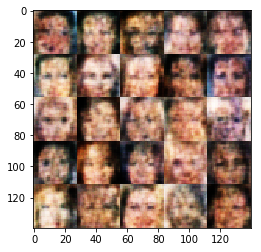

Epoch 1/1... Discriminator Loss: 0.2888... Generator Loss: 1.7548
Epoch 1/1... Discriminator Loss: 0.2766... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 4.5069
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 2.3881
Epoch 1/1... Discriminator Loss: 2.6500... Generator Loss: 0.1553
Epoch 1/1... Discriminator Loss: 3.8511... Generator Loss: 0.0704
Epoch 1/1... Discriminator Loss: 1.9534... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.3168... Generator Loss: 1.6874
Epoch 1/1... Discriminator Loss: 2.5792... Generator Loss: 0.1034


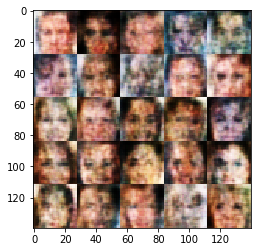

Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 1.8666
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.0881... Generator Loss: 4.4263
Epoch 1/1... Discriminator Loss: 0.1456... Generator Loss: 2.9803
Epoch 1/1... Discriminator Loss: 3.3864... Generator Loss: 0.0429


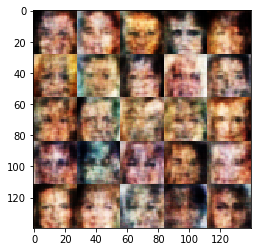

Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 2.2801
Epoch 1/1... Discriminator Loss: 0.3031... Generator Loss: 2.5751
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.2423... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 5.2307
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 4.3829


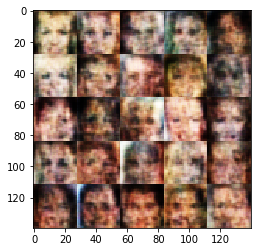

Epoch 1/1... Discriminator Loss: 0.2662... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 2.1256
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 4.0920
Epoch 1/1... Discriminator Loss: 0.1462... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 0.0720... Generator Loss: 3.9855
Epoch 1/1... Discriminator Loss: 0.1655... Generator Loss: 2.3969
Epoch 1/1... Discriminator Loss: 4.3232... Generator Loss: 1.5023
Epoch 1/1... Discriminator Loss: 2.0776... Generator Loss: 2.0910
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 0.9332


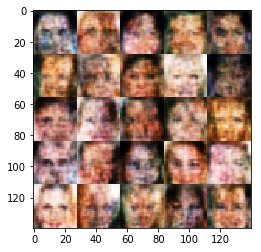

Epoch 1/1... Discriminator Loss: 2.8466... Generator Loss: 0.1394
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 2.5198... Generator Loss: 2.2418
Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 1.9914
Epoch 1/1... Discriminator Loss: 0.3217... Generator Loss: 2.6505
Epoch 1/1... Discriminator Loss: 0.1701... Generator Loss: 2.8431
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 1.2637


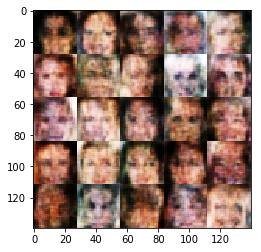

Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 3.1150
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.9686
Epoch 1/1... Discriminator Loss: 0.1062... Generator Loss: 2.9975
Epoch 1/1... Discriminator Loss: 3.0472... Generator Loss: 5.2273
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.8170
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.6503
Epoch 1/1... Discriminator Loss: 2.0056... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.4378


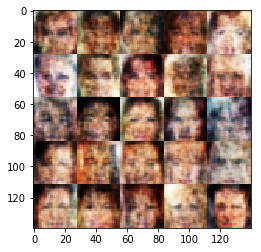

Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 1.8916
Epoch 1/1... Discriminator Loss: 0.1086... Generator Loss: 2.8510
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.3404
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 2.3573... Generator Loss: 2.8363
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.5111


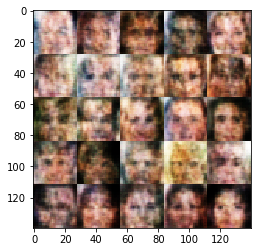

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.3078
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 1.8850
Epoch 1/1... Discriminator Loss: 3.0033... Generator Loss: 0.0878
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.3220
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 0.1682... Generator Loss: 4.1278
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 2.3165


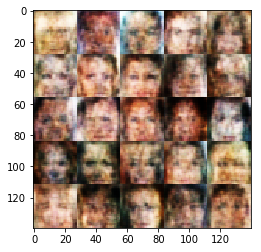

Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 4.3092
Epoch 1/1... Discriminator Loss: 0.1126... Generator Loss: 4.0431
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 2.5404
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 1.8272
Epoch 1/1... Discriminator Loss: 0.1283... Generator Loss: 2.7313
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 0.1156... Generator Loss: 4.5205
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 2.9400
Epoch 1/1... Discriminator Loss: 2.4324... Generator Loss: 0.1433


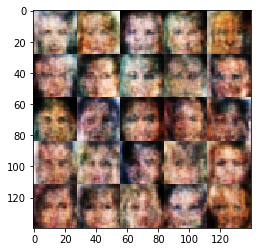

Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.7978
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 1.9302... Generator Loss: 0.1914
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 0.9481


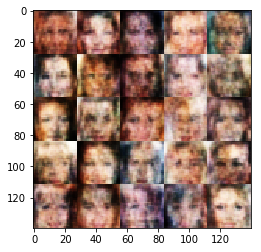

Epoch 1/1... Discriminator Loss: 0.1455... Generator Loss: 2.8433
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 2.1724
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 1.3842
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 4.1792
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 2.3143
Epoch 1/1... Discriminator Loss: 2.7623... Generator Loss: 0.0859
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 3.8632
Epoch 1/1... Discriminator Loss: 0.2909... Generator Loss: 1.6591


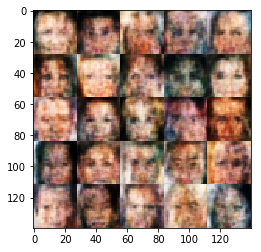

Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 4.0613
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 3.2342
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 1.8419
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 2.8458
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 1.3813
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 3.6961... Generator Loss: 4.1933


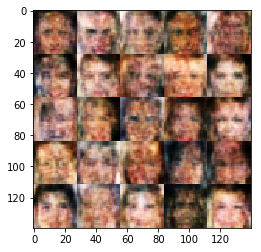

Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.7788
Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.2650
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 2.8454
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 2.3460
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 2.1145
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 2.7876... Generator Loss: 0.0872
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.6981


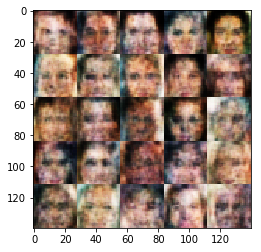

Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.3185
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 3.3384
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 3.1400
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 2.5550
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 1.2051


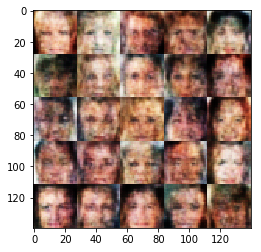

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 2.0611


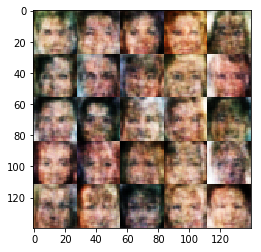

Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.9352
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.6928
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 0.1675... Generator Loss: 2.9759
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 0.7302


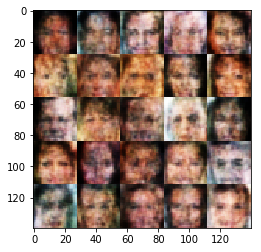

Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.2381
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 2.0217... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.7189... Generator Loss: 0.2636
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 0.2823... Generator Loss: 1.7253


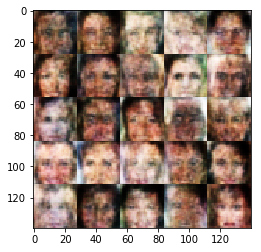

Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 2.2142... Generator Loss: 3.7327
Epoch 1/1... Discriminator Loss: 0.2313... Generator Loss: 2.0238
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 3.5891... Generator Loss: 0.0708
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 3.0264... Generator Loss: 0.0690
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.3141


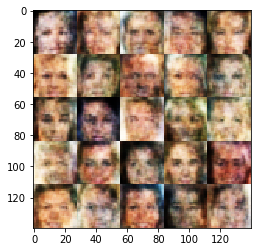

Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.3082
Epoch 1/1... Discriminator Loss: 0.1973... Generator Loss: 2.7011
Epoch 1/1... Discriminator Loss: 0.2017... Generator Loss: 2.3250
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 2.4225
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 0.7946


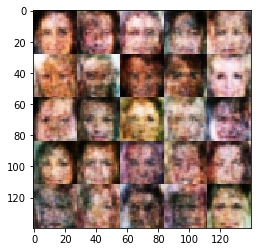

Epoch 1/1... Discriminator Loss: 0.2754... Generator Loss: 1.8008
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.2852
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 1.2519
Epoch 1/1... Discriminator Loss: 0.2360... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 2.4348


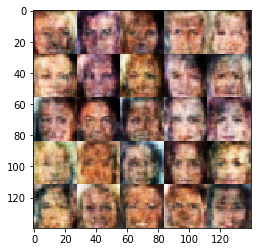

Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 1.9382... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 3.1386
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 0.3283... Generator Loss: 2.3639
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 1.2567


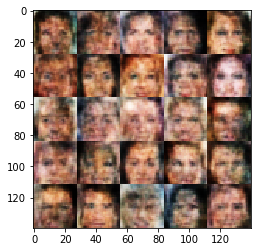

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 6.1455
Epoch 1/1... Discriminator Loss: 0.1011... Generator Loss: 3.1071
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 2.7255... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 0.1084... Generator Loss: 3.0401


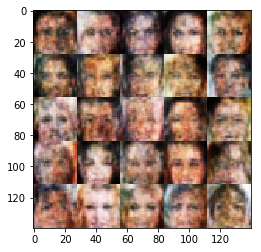

Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 3.7529
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 0.2757... Generator Loss: 1.7139
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 3.8657
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.5231


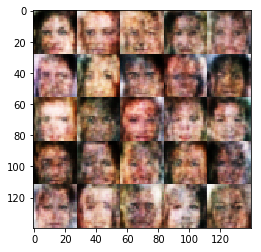

Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 2.1818... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 2.5599... Generator Loss: 0.0959
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 1.0965


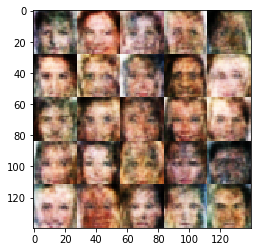

Epoch 1/1... Discriminator Loss: 0.1141... Generator Loss: 2.5880
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 1.4992
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.0721... Generator Loss: 4.4489
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 2.5457... Generator Loss: 0.1104
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 0.9184


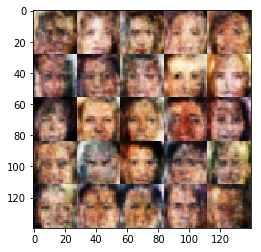

Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 0.1617... Generator Loss: 3.1812
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.8720... Generator Loss: 0.2849
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.5445


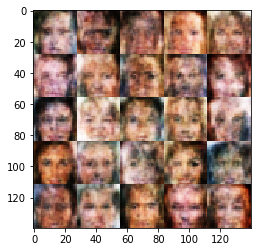

Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 1.5188
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.1902... Generator Loss: 2.3253
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.2887


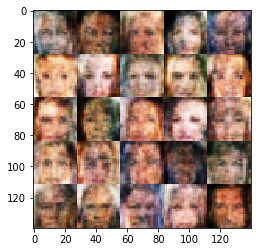

Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.2508... Generator Loss: 1.8350
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.7000
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 0.2918... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 2.0760... Generator Loss: 3.7517


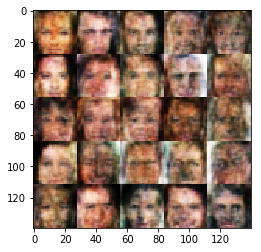

Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 2.4996... Generator Loss: 0.1298
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.6733... Generator Loss: 0.2582
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.2185... Generator Loss: 2.2622
Epoch 1/1... Discriminator Loss: 3.1704... Generator Loss: 0.0780


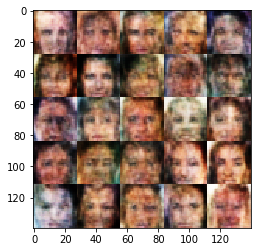

Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.8288
Epoch 1/1... Discriminator Loss: 2.4913... Generator Loss: 3.1269
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.9714
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 2.1284... Generator Loss: 0.3032
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 0.8293


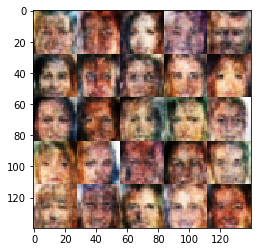

Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 1.7056
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 1.8607
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 2.1356... Generator Loss: 2.7187


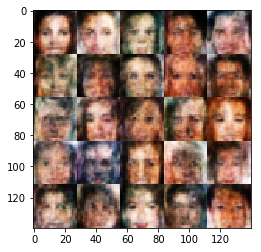

Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 0.2498... Generator Loss: 1.8884
Epoch 1/1... Discriminator Loss: 0.2820... Generator Loss: 1.7019
Epoch 1/1... Discriminator Loss: 0.1742... Generator Loss: 2.8130
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.1342... Generator Loss: 2.5480
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 1.9562
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 2.2095


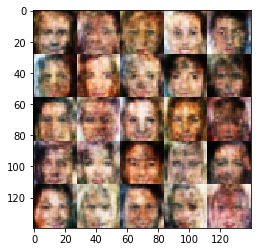

Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 2.4021... Generator Loss: 0.1164
Epoch 1/1... Discriminator Loss: 0.0869... Generator Loss: 3.5585
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 2.1104
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 1.2798


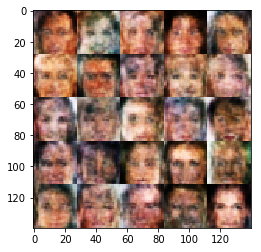

Epoch 1/1... Discriminator Loss: 3.6082... Generator Loss: 0.0498
Epoch 1/1... Discriminator Loss: 2.8336... Generator Loss: 0.2854
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.2768
Epoch 1/1... Discriminator Loss: 0.1352... Generator Loss: 3.7351
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 0.2734... Generator Loss: 2.0665
Epoch 1/1... Discriminator Loss: 1.8659... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 0.7159


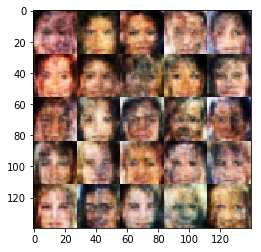

Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 2.7171
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 3.2661
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 2.2138
Epoch 1/1... Discriminator Loss: 0.2053... Generator Loss: 4.1288
Epoch 1/1... Discriminator Loss: 0.1263... Generator Loss: 3.3331
Epoch 1/1... Discriminator Loss: 0.2504... Generator Loss: 2.3660
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.0204


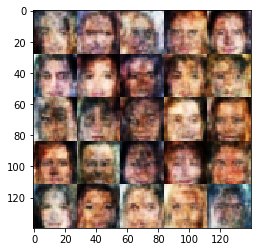

Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 2.2750
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 2.9693... Generator Loss: 0.0955
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 0.9417


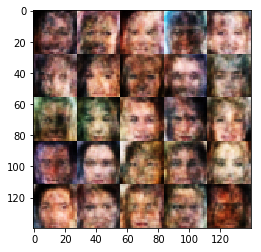

Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.2304... Generator Loss: 3.2760
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 3.7739
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 2.0940


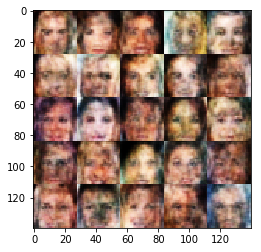

Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 0.1520... Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.0598... Generator Loss: 4.1895
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 2.1662
Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 3.0437
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 0.2871... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 1.6057


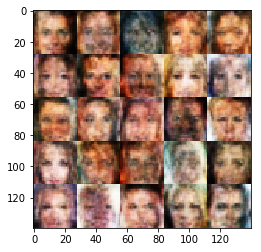

Epoch 1/1... Discriminator Loss: 0.2402... Generator Loss: 2.0199
Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.8950
Epoch 1/1... Discriminator Loss: 1.8563... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.3225... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 1.5344
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 0.8091


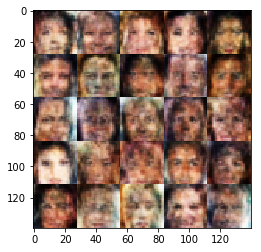

Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.2300
Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 2.4966
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 1.7149
Epoch 1/1... Discriminator Loss: 0.2374... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 1.5823


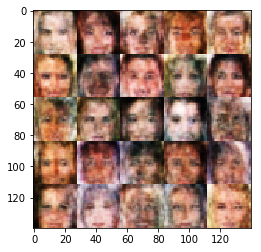

Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.2808
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 2.1428
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 1.8084
Epoch 1/1... Discriminator Loss: 1.6845... Generator Loss: 0.2732
Epoch 1/1... Discriminator Loss: 2.1189... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 1.2163


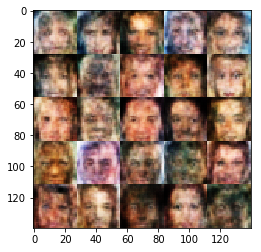

Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 0.2829... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 2.8905
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 3.1813
Epoch 1/1... Discriminator Loss: 0.3155... Generator Loss: 1.7588
Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 2.4724
Epoch 1/1... Discriminator Loss: 2.3033... Generator Loss: 0.1458
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.8510


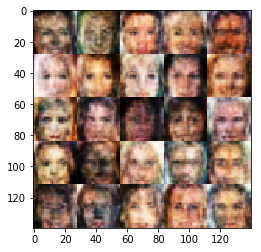

Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 1.4424
Epoch 1/1... Discriminator Loss: 0.2728... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 0.2687... Generator Loss: 1.6527


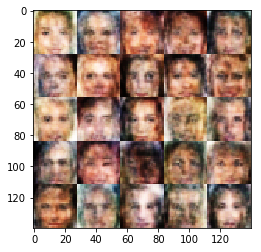

Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 3.9307
Epoch 1/1... Discriminator Loss: 0.2002... Generator Loss: 2.3000
Epoch 1/1... Discriminator Loss: 0.2895... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 3.0216
Epoch 1/1... Discriminator Loss: 2.8311... Generator Loss: 2.1605
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 1.6652


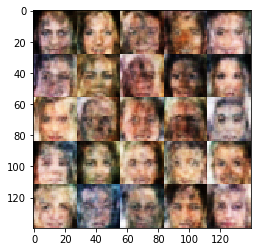

Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 2.7823
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 2.1491
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.2037... Generator Loss: 2.4988
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 2.4149


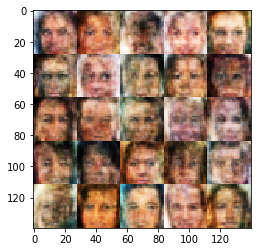

Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 2.0149
Epoch 1/1... Discriminator Loss: 0.2081... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 3.0906
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 1.8551
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 2.7670
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.2492... Generator Loss: 2.3852
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 1.0498


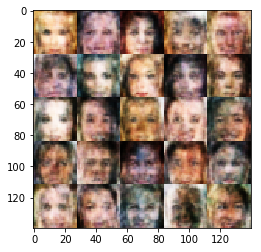

Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 1.3444
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 2.2040... Generator Loss: 0.1467
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 2.4794
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.4000
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 0.2132... Generator Loss: 2.3640
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 1.9792


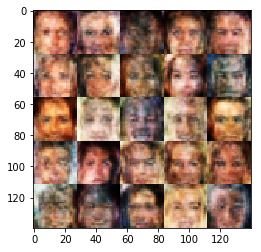

Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.6639... Generator Loss: 0.3042
Epoch 1/1... Discriminator Loss: 0.2092... Generator Loss: 2.5747
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 3.8707
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.2466... Generator Loss: 2.3842
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 1.1497


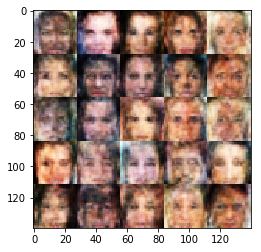

Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 2.4309
Epoch 1/1... Discriminator Loss: 0.3016... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 2.5314... Generator Loss: 0.1286
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.7679... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 2.0854


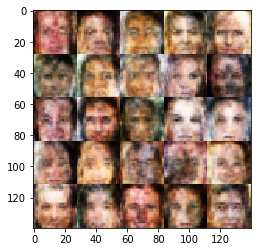

Epoch 1/1... Discriminator Loss: 1.7059... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.8531
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.5491
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 0.2358... Generator Loss: 1.9394
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 1.6251
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 1.6537


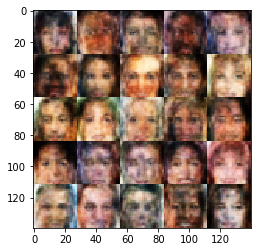

Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 3.3625
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.0259
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 1.4503


In [46]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)